In [1]:
import json
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
from prototypes.classical.descriptors.texture import LBPTransformer, HoGTransformer, GaborTransformer
from prototypes.classical.dataloader.Loader import IsiCancerData
from prototypes.classical.descriptors.vetorizer import LBPVectorizer

%load_ext autoreload
%autoreload 2

with open("../config.json", "r") as f:
    config = json.load(f)

In [2]:
train_csv = pd.read_csv(config["TRAIN_METADATA"])

/tmp/ipykernel_59932/550750344.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_csv = pd.read_csv(config["TRAIN_METADATA"])


In [3]:
train_csv.shape

(401059, 55)

In [4]:
train_csv.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [6]:
train_csv.groupby(by="target")[["target"]].count()

,target
target,
0,400666
1,393


In [8]:
train_csv.query("target==1").head(5)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
387,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
935,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
1245,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
1846,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
3478,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846


(137, 137, 3)


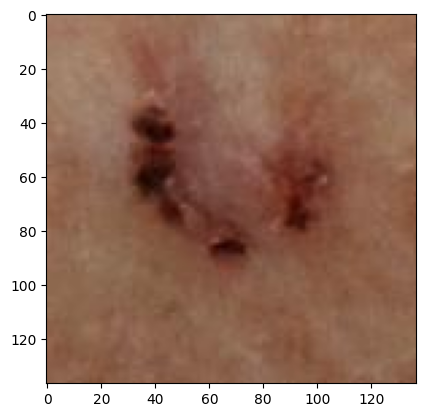

In [15]:
image_file_name = train_csv.query("target==1").to_numpy()[0][0] + ".jpg" #os.listdir(config["TRAIN_IMAGES_PATH"])[8]

cancer_image = cv2.imread(os.path.join(config["TRAIN_IMAGES_PATH"], image_file_name), cv2.IMREAD_COLOR)[:,:,::-1]
plt.imshow(cancer_image)
print(cancer_image.shape)

In [14]:
dataset = IsiCancerData(config)

# Texture Study

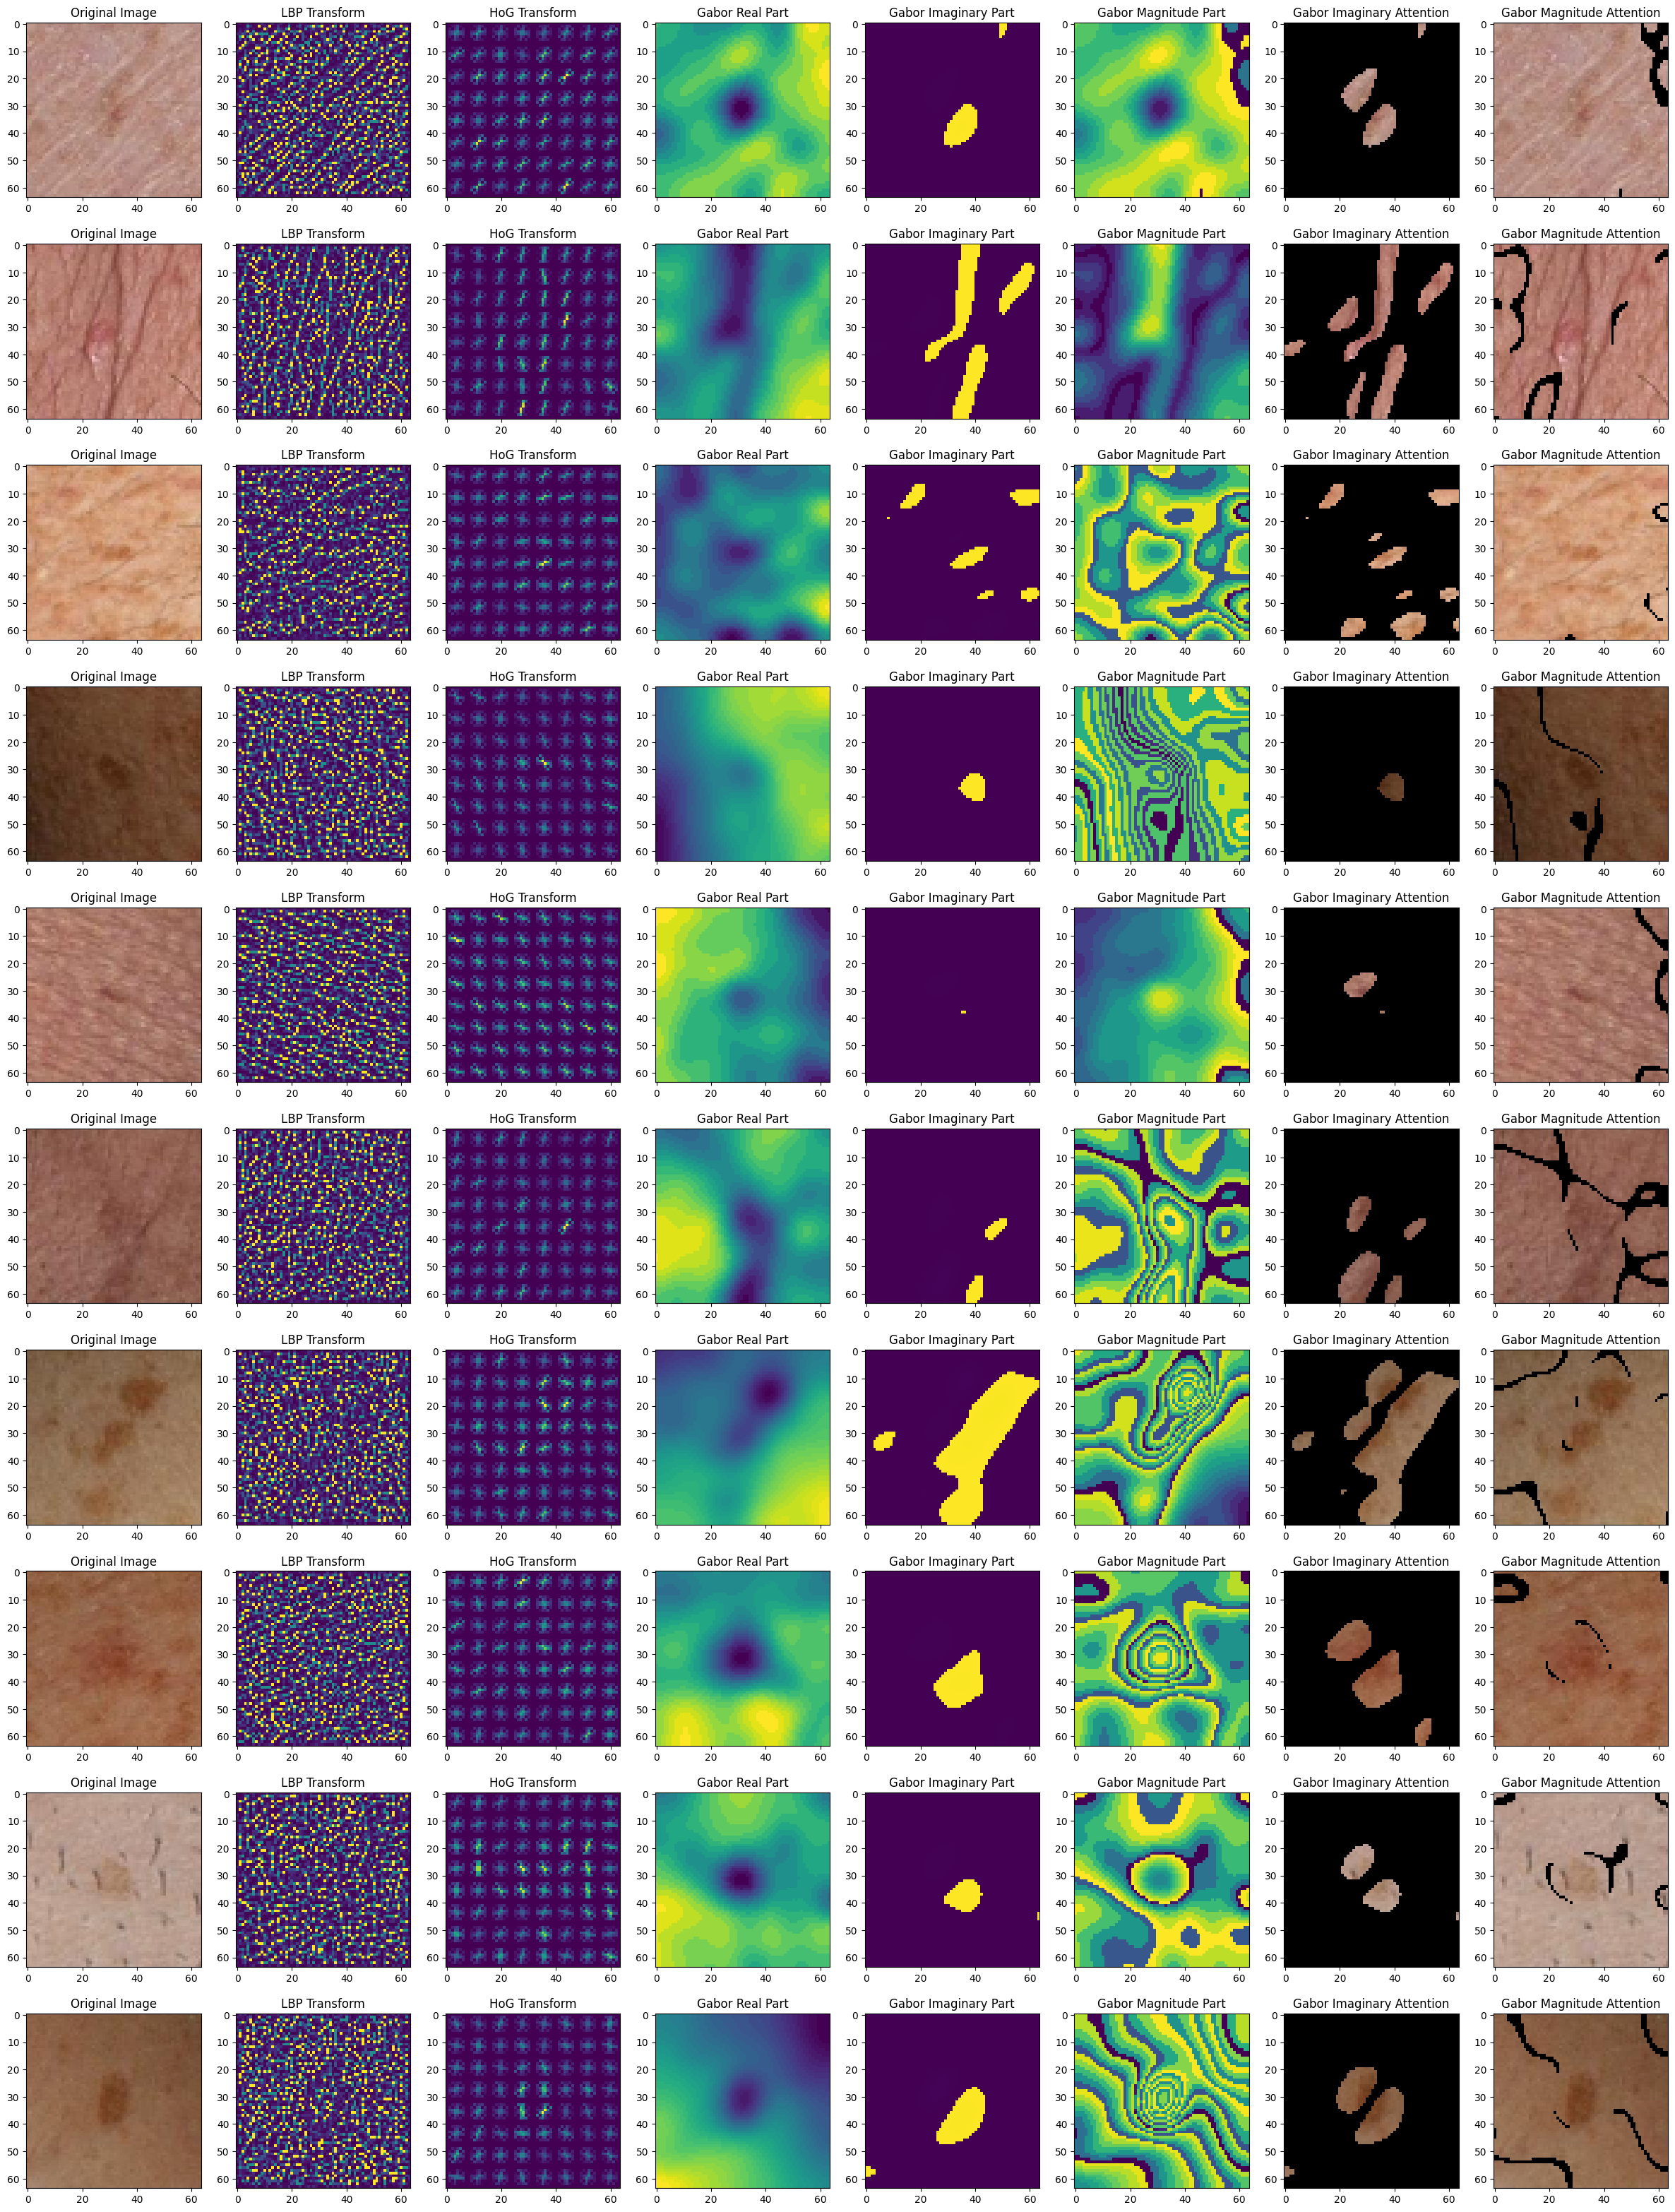

In [7]:
IMAGES = 10
fig, ax = plt.subplots(IMAGES, 8, figsize=(30, 40))


for i in range(IMAGES):
    image, labels = dataset.get_item()

    gabor_transformer = GaborTransformer(frequency=1/100, theta=np.pi/4, sigma_x=5, sigma_y=5)
    lbp_transformer = LBPTransformer(p=8, r=1)
    hog_transformer = HoGTransformer(orientations=8,
                                     pixels_per_cell=(8, 8),
                                     cells_per_block=(2, 2),
                                     visualize=True)
    
    ax[i, 0].imshow(image[:, :, ::-1])
    ax[i, 0].set_title("Original Image")
    ax[i, 1].imshow(lbp_transformer.transform(image))
    ax[i, 1].set_title("LBP Transform")
    ax[i, 2].imshow(hog_transformer.transform(image)[1])
    ax[i, 2].set_title("HoG Transform")
    
    gabor_map = gabor_transformer.transform(image)
    gabor_magnitude = np.sqrt(gabor_map[0]**2 + gabor_map[1]**2)
    
    ax[i, 3].imshow(gabor_map[0])
    ax[i, 3].set_title("Gabor Real Part")
    ax[i, 4].imshow(gabor_map[1])
    ax[i, 4].set_title("Gabor Imaginary Part")
    ax[i, 5].imshow(gabor_magnitude)
    ax[i, 5].set_title("Gabor Magnitude Part")
    
    imag_attention_map = image.copy()
    
    imag_attention_map[:, :, 0] = imag_attention_map[:, :, 0] * (gabor_map[1] > 0)
    imag_attention_map[:, :, 1] = imag_attention_map[:, :, 1] * (gabor_map[1] > 0)
    imag_attention_map[:, :, 2] = imag_attention_map[:, :, 2] * (gabor_map[1] > 0)
    
    magnitude_attention_map = image.copy()
    
    magnitude_attention_map[:, :, 0] = magnitude_attention_map[:, :, 0] * (gabor_magnitude > 0)
    magnitude_attention_map[:, :, 1] = magnitude_attention_map[:, :, 1] * (gabor_magnitude > 0)
    magnitude_attention_map[:, :, 2] = magnitude_attention_map[:, :, 2] * (gabor_magnitude > 0)
    
    ax[i, 6].imshow(imag_attention_map[:, :, ::-1])
    ax[i, 6].set_title("Gabor Imaginary Attention")
    ax[i, 7].imshow(magnitude_attention_map[:, :, ::-1])
    ax[i, 7].set_title("Gabor Magnitude Attention")

# Gabor bank feature vector

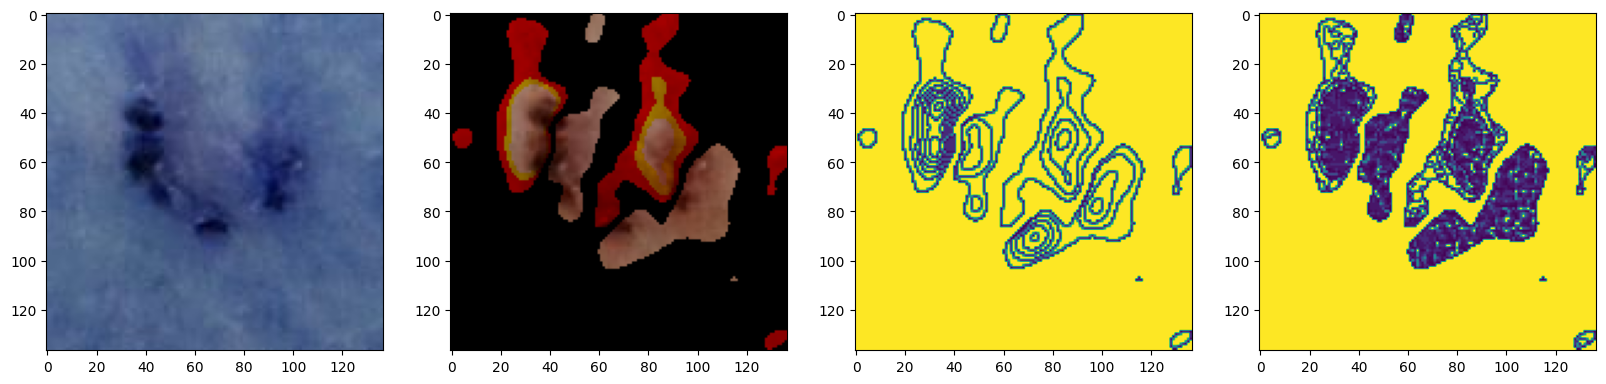

In [16]:
dataset.reset_index()

image, labels = dataset.get_item()

image = cancer_image

gabor_transformer = GaborTransformer(frequency=1/100, theta=np.pi/4, sigma_x=5, sigma_y=5)
lbp_transformer = LBPTransformer(p=8, r=1)

gabor_filter_bank = gabor_transformer.transform(image)

imag_attention_map = image.copy()
imag_attention_map[:, :, 0] = imag_attention_map[:, :, 0] * (gabor_filter_bank[1] > 0)
imag_attention_map[:, :, 1] = imag_attention_map[:, :, 1] * (gabor_filter_bank[1] > 1)
imag_attention_map[:, :, 2] = imag_attention_map[:, :, 2] * (gabor_filter_bank[1] > 2)

fig, ax = plt.subplots(1, 4, figsize=(20, 20))

ax[0].imshow(image[:, :, ::-1])
ax[1].imshow(imag_attention_map)
ax[2].imshow(lbp_transformer.transform(gabor_filter_bank[1]))
ax[3].imshow(lbp_transformer.transform(imag_attention_map))

In [9]:
feature_vector = LBPVectorizer().transform(lbp_transformer.transform(imag_attention_map))

In [10]:
feature_vector.sum()

1.0

# Batches

In [11]:
dataset = IsiCancerData(config_file=config)

/home/matias/workspace/ISIC-2024-Skin-Cancer-Detection-3D-TBP/prototypes/classical/dataloader/Loader.py:10: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.train = pd.read_csv(config_file["TRAIN_METADATA"]).to_numpy()


In [12]:
batch = next(iter(dataset.get_next_batch()))

In [13]:
batch[0].shape, batch[1].shape

((2048, 64, 64, 3), (2047, 55))

In [14]:
from tqdm.auto import tqdm

images_batches = []
labels_batches = []

for batch in tqdm(dataset.get_next_batch(), total=dataset.total_samples()):
    images_batches.append(batch[0])
    labels_batches.append(batch[1])

  0%|          | 0/195 [00:00<?, ?it/s]

break


In [15]:
images_batches[0].shape

(2048, 64, 64, 3)

In [16]:
images_batches[0][0].max()

207.0

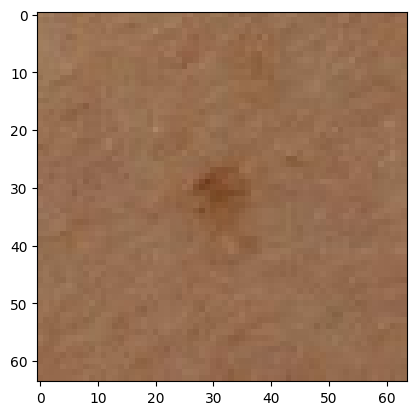

In [17]:
plt.imshow(images_batches[0][-1].astype(np.uint8)[:,:,::-1])

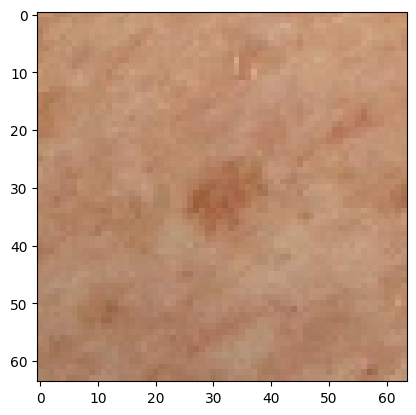

In [18]:
plt.imshow(images_batches[0][2].astype(np.uint8)[:,:,::-1])